In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [28]:
def load_yolo(config_path, weights_path, classes_path):
    # Load YOLO model
    net = cv2.dnn.readNet(weights_path, config_path)

    # Load class names
    with open(classes_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]

    # Get the output layer names
    layer_names = net.getLayerNames()
    
    # Adjusted line to handle both array formats
    output_layers_indices = net.getUnconnectedOutLayers()
    
    # Check if output_layers_indices is a 1D array
    if output_layers_indices.ndim == 1:
        output_layers = [layer_names[i - 1] for i in output_layers_indices]
    else:
        output_layers = [layer_names[i[0] - 1] for i in output_layers_indices]

    return net, output_layers, classes


In [21]:
# Load an image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not open or find the image at '{image_path}'")
        return None
    return image

In [22]:
#Detect objects in image

def detect_objects(net, output_layers, image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Adjust confidence threshold as needed
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    return boxes, confidences, class_ids

In [23]:
# Draw bounding boxes on the image
def draw_labels(boxes, confidences, class_ids, classes, image):
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)  # Non-max suppression

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i], 2))
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, label + " " + confidence, (x, y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

In [26]:
# Main function
def main():
    # Paths to YOLO files
    config_path = "data/yolov3.cfg"  # Replace with the path to your YOLO config file
    weights_path = "data/yolov3.weights"  # Replace with the path to your YOLO weights file
    classes_path = "data/coco.names"  # Replace with the path to your class names file

    # Load YOLO model
    net, output_layers, classes = load_yolo(config_path, weights_path, classes_path)

    # Load an image
    image_path = "images/training_images/vid_4_600.jpg"  # Replace with your image file name
    image = load_image(image_path)

    if image is not None:
        # Detect objects
        boxes, confidences, class_ids = detect_objects(net, output_layers, image)
        
        # Draw labels on the image
        draw_labels(boxes, confidences, class_ids, classes, image)

        # Convert BGR to RGB for displaying with Matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.imshow(image)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()


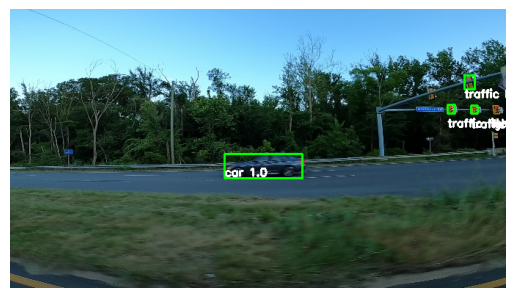

In [29]:
# Execute the main function
if __name__ == "__main__":
    main()